In [43]:
# 1) Imports
import os, json, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, RocCurveDisplay, classification_report)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import joblib


In [44]:
# 2) Load data
df = pd.read_csv('../Data/Titanic-Dataset.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [45]:
# 3) Basic info
print("Shape:", df.shape)
print("\nColumns & dtypes:")
print(df.dtypes)
print("\nMissing values per column:")
print(df.isna().sum())

Shape: (891, 12)

Columns & dtypes:
PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

Missing values per column:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


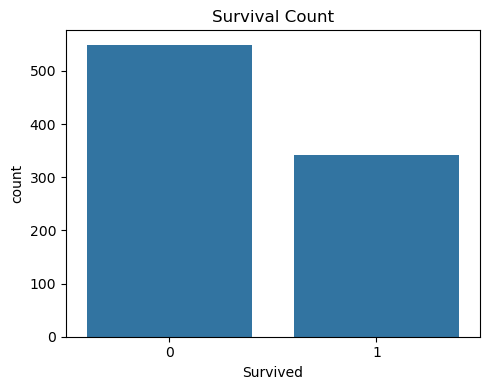

In [46]:
# 4) EDA plots
plt.figure(figsize=(5,4))
sns.countplot(data=df, x='Survived')
plt.title('Survival Count')
plt.tight_layout()
plt.show()

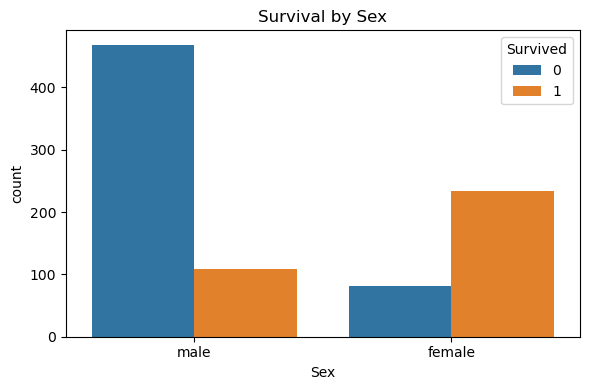

In [47]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Sex', hue='Survived')
plt.title('Survival by Sex')
plt.tight_layout()
plt.show()

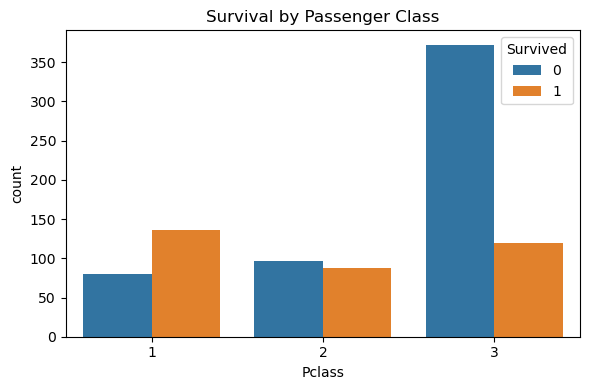

In [48]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Pclass', hue='Survived')
plt.title('Survival by Passenger Class')
plt.tight_layout()
plt.show()

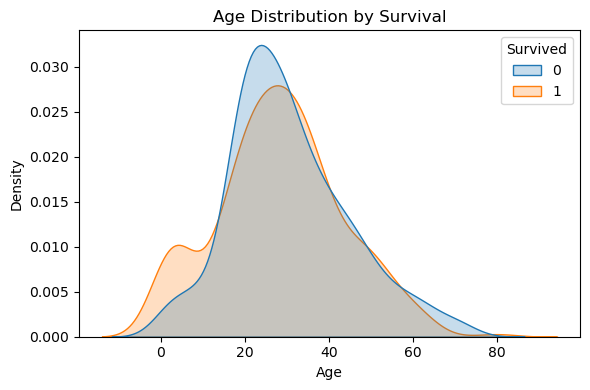

In [49]:
plt.figure(figsize=(6,4))
sns.kdeplot(data=df, x='Age', hue='Survived', common_norm=False, fill=True)
plt.title('Age Distribution by Survival')
plt.tight_layout()
plt.show()

In [50]:
# 5) Choose target and features
TARGET = 'Survived'

# Columns present in the Kaggle Titanic dataset
drop_cols = ['PassengerId', 'Name', 'Ticket', 'Cabin']  # high‑cardinality / IDs not predictive
x_cols = [c for c in df.columns if c not in drop_cols + [TARGET]]

X = df[x_cols].copy()
y = df[TARGET].copy()

# Identify categorical vs numeric features automatically
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()

categorical_features, numeric_features

(['Sex', 'Embarked'], ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare'])

In [51]:
# 6) Preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [52]:
# Store feature info for the app
import shutil
feature_info = {
    'target': TARGET,
    'numeric_features': numeric_features,
    'categorical_features': categorical_features,
    'used_features': x_cols
}
with open('feature_info.json', 'w') as f:
    json.dump(feature_info, f, indent=2)
print("Saved feature_info.json in notebook folder")
shutil.copy('feature_info.json', '../feature_info.json')
print("Copied feature_info.json to project root")

Saved feature_info.json in notebook folder
Copied feature_info.json to project root


In [53]:
# 7) Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
X_train.shape, X_test.shape

((712, 7), (179, 7))

In [54]:
# 8) Define candidate models with reasonable hyperparam grids
models = {
    'LogisticRegression': (
        LogisticRegression(max_iter=1000, random_state=42),
        {
            'clf__C': [0.1, 1.0, 10.0],
            'clf__penalty': ['l2'],
            'clf__solver': ['lbfgs']
        }
    ),
    'RandomForest': (
        RandomForestClassifier(random_state=42),
        {
            'clf__n_estimators': [100, 300],
            'clf__max_depth': [None, 5, 10],
            'clf__min_samples_split': [2, 5]
        }
    ),
    'SVC': (
        SVC(probability=True, random_state=42),
        {
            'clf__C': [0.5, 1.0, 5.0],
            'clf__kernel': ['rbf', 'linear'],
            'clf__gamma': ['scale']
        }
    )
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = {}

for name, (clf, param_grid) in models.items():
    pipe = Pipeline(steps=[('preprocess', preprocess), ('clf', clf)])
    grid = GridSearchCV(pipe, param_grid=param_grid, cv=cv, scoring='accuracy', n_jobs=-1, refit=True)
    grid.fit(X_train, y_train)

    # Cross‑validated performance (best params)
    best_cv_score = grid.best_score_
    best_params = grid.best_params_

    # Evaluate on the test split
    y_proba = grid.predict_proba(X_test)[:, 1]
    y_pred = grid.predict(X_test)

    metrics = {
        'cv_mean_accuracy': float(best_cv_score),
        'best_params': best_params,
        'test_accuracy': float(accuracy_score(y_test, y_pred)),
        'test_precision': float(precision_score(y_test, y_pred)),
        'test_recall': float(recall_score(y_test, y_pred)),
        'test_f1': float(f1_score(y_test, y_pred)),
        'test_roc_auc': float(roc_auc_score(y_test, y_proba))
    }
    cv_results[name] = metrics
    print(f"\n{name} — best CV accuracy: {best_cv_score:.4f}, test acc: {metrics['test_accuracy']:.4f}")
    print("Best params:", best_params)

cv_results



LogisticRegression — best CV accuracy: 0.7963, test acc: 0.8045
Best params: {'clf__C': 1.0, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}

RandomForest — best CV accuracy: 0.8259, test acc: 0.8101
Best params: {'clf__max_depth': 10, 'clf__min_samples_split': 5, 'clf__n_estimators': 300}

RandomForest — best CV accuracy: 0.8259, test acc: 0.8101
Best params: {'clf__max_depth': 10, 'clf__min_samples_split': 5, 'clf__n_estimators': 300}

SVC — best CV accuracy: 0.8272, test acc: 0.7989
Best params: {'clf__C': 5.0, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}

SVC — best CV accuracy: 0.8272, test acc: 0.7989
Best params: {'clf__C': 5.0, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}


{'LogisticRegression': {'cv_mean_accuracy': 0.7963459076135132,
  'best_params': {'clf__C': 1.0, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'},
  'test_accuracy': 0.8044692737430168,
  'test_precision': 0.7931034482758621,
  'test_recall': 0.6666666666666666,
  'test_f1': 0.7244094488188977,
  'test_roc_auc': 0.8437417654808959},
 'RandomForest': {'cv_mean_accuracy': 0.825854427262878,
  'best_params': {'clf__max_depth': 10,
   'clf__min_samples_split': 5,
   'clf__n_estimators': 300},
  'test_accuracy': 0.8100558659217877,
  'test_precision': 0.8181818181818182,
  'test_recall': 0.6521739130434783,
  'test_f1': 0.7258064516129032,
  'test_roc_auc': 0.8324110671936759},
 'SVC': {'cv_mean_accuracy': 0.8272431793558555,
  'best_params': {'clf__C': 5.0, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'},
  'test_accuracy': 0.7988826815642458,
  'test_precision': 0.8113207547169812,
  'test_recall': 0.6231884057971014,
  'test_f1': 0.7049180327868853,
  'test_roc_auc': 0.8221343873517787}}

In [55]:
# 9) Select the best model by validation score, refit on full training data, and evaluate
best_model_name = max(cv_results.keys(), key=lambda k: cv_results[k]['cv_mean_accuracy'])
print("Selected best model:", best_model_name)

# Recreate the best pipeline with best params and refit on X_train
best_clf, best_param_grid = models[best_model_name]
best_pipe = Pipeline(steps=[('preprocess', preprocess), ('clf', best_clf)])

# Apply the best params again:
best_params = cv_results[best_model_name]['best_params']
for k, v in best_params.items():
    component, param = k.split('__', 1)
    if component == 'clf':
        best_pipe.named_steps['clf'].set_params(**{param: v})

best_pipe.fit(X_train, y_train)

# Test set evaluation
y_pred = best_pipe.predict(X_test)
y_proba = best_pipe.predict_proba(X_test)[:, 1]

test_metrics = {
    'accuracy': float(accuracy_score(y_test, y_pred)),
    'precision': float(precision_score(y_test, y_pred)),
    'recall': float(recall_score(y_test, y_pred)),
    'f1': float(f1_score(y_test, y_pred)),
    'roc_auc': float(roc_auc_score(y_test, y_proba))
}
print("Test metrics:", test_metrics)

Selected best model: SVC
Test metrics: {'accuracy': 0.7988826815642458, 'precision': 0.8113207547169812, 'recall': 0.6231884057971014, 'f1': 0.7049180327868853, 'roc_auc': 0.8221343873517787}


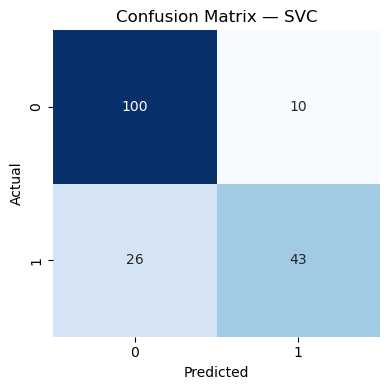

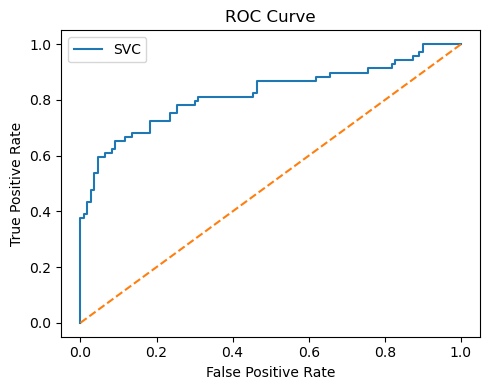

In [56]:
# 10) Confusion matrix & ROC curves on test set (and save images)
from sklearn.metrics import roc_curve

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', cbar=False, cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix — {best_model_name}')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150)
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"{best_model_name}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.tight_layout()
plt.savefig('roc_curve.png', dpi=150)
plt.show()


In [57]:
# 11) Save metrics summary
summary = {
    'best_model': best_model_name,
    'cv_results': cv_results,
    'test_metrics': test_metrics
}
with open('../metrics.json', 'w') as f:
    json.dump(summary, f, indent=2)
print("Saved metrics.json")


Saved metrics.json


In [58]:
# 12) Train final production model on the FULL dataset and save to model.pkl
# Rationale: use all data for best generalization in production.
final_clf, _ = models[summary['best_model']]
final_pipe = Pipeline(steps=[('preprocess', preprocess), ('clf', final_clf)])

# Apply best params again
best_params = summary['cv_results'][summary['best_model']]['best_params']
for k, v in best_params.items():
    component, param = k.split('__', 1)
    if component == 'clf':
        final_pipe.named_steps['clf'].set_params(**{param: v})

final_pipe.fit(X, y)
joblib.dump(final_pipe, '../model.pkl')
with open('../feature_info.json', 'w') as f:
    json.dump({
        'target': TARGET,
        'numeric_features': numeric_features,
        'categorical_features': categorical_features,
        'used_features': x_cols
    }, f, indent=2)
print("Saved model.pkl")

Saved model.pkl
